load data
plot data

In [1]:
import numpy as np
import pickle
import pandas as pd
import time
from umap import UMAP

In [2]:
from tfumap.paths import ensure_dir, MODEL_DIR, DATA_DIR

In [3]:
from tfumap.paths import FIGURE_DIR, save_fig

In [4]:
save_loc = DATA_DIR / 'knn_classifier' 

In [5]:
datasets = [
    'cassins_dtw',
    'cifar10',
    'fmnist',
    'macosko2015',
    'mnist'
]

In [6]:
projection_speeds = pd.concat([pd.read_pickle(save_loc / (dataset + '.pickle')) for dataset in datasets])
projection_speeds[:3]

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cassins_dtw,0.991,0.995
1,network,64,cassins_dtw,0.988,0.991
2,autoencoder,2,cassins_dtw,0.989,0.993


In [7]:
for dataset in datasets:
    for n_components in ['2', '64']:
        save_loc =  DATA_DIR / 'knn_classifier' / str(n_components) / (dataset + '.pickle')
        try:
            metric_df = pd.read_pickle(save_loc)
            projection_speeds = pd.concat([projection_speeds, metric_df])
        except FileNotFoundError:
            print(save_loc)

In [8]:
projection_speeds[-5:]

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,parametric-tsne,64,fmnist,0.830000,0.847900
0,parametric-tsne,2,macosko2015,0.966079,0.976568
0,parametric-tsne,64,macosko2015,0.977237,0.981254
0,parametric-tsne,2,mnist,0.911800,0.937800
0,parametric-tsne,64,mnist,0.969700,0.973400


In [9]:
projection_speeds.loc[projection_speeds.dataset == 'cassins', 'dataset'] = 'cassins_dtw'
#projection_speeds.loc[projection_speeds.dataset == 'makosco2015', 'dataset'] = 'macoco2015'

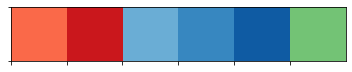

In [10]:
import seaborn as sns

palette = (
    sns.color_palette("Reds", 3)[1:]
    + sns.color_palette("Blues", 5)[2:]
    + sns.color_palette("Greens", 1)
)
sns.palplot(palette)

### K=1

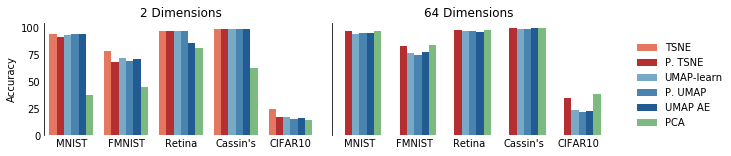

In [11]:
median_df = (
    projection_speeds[["method_", "dimensions", "dataset", "1NN_acc"]]
    .groupby(["method_", "dimensions", "dataset"])
    .median()
)
median_df = median_df.T.melt()
median_df["value"]*=100
median_df["error"] = 100 - median_df["value"]
fg = sns.catplot(
    x="dataset",
    y="value",
    hue="method_",
    hue_order=["TSNE", "parametric-tsne", "umap-learn", "network", "autoencoder", "PCA"],
    order=["mnist", "fmnist", "macosko2015", "cassins_dtw", "cifar10"],
    col="dimensions",
    height=2.5,
    aspect=1.75,
    data=median_df,
    kind="bar",
    palette=palette,
    # legend=False
)
(
    fg.despine(bottom=True)
    .set_xticklabels(["MNIST", "FMNIST", "Retina", "Cassin's", "CIFAR10"])
    .set_axis_labels("", "Accuracy")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u"both", which=u"both", length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "umap-learn"))[0][0]
].set_text("UMAP-learn")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "network"))[0][0]
].set_text("P. UMAP")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "autoencoder"))[0][0]
].set_text("UMAP AE")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
# fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'pca'))[0][0]].set_text('PCA')
# fg._legend.texts[3].set_text("PCA")
# ax.set_ylim([1e-10,1e-3])
# ax.set_yscale('log')
# fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title("2 Dimensions")
ax = fg.axes[0][1]
ax.tick_params(axis=u"both", which=u"both", length=0)

ax.set_title("64 Dimensions")
# ax.set_yscale('log')

save_fig(FIGURE_DIR/'1nn_acc_results', save_pdf=True, dpi=300, pad_inches=0.1)

Text(0.5, 1, '64 Dimensions')

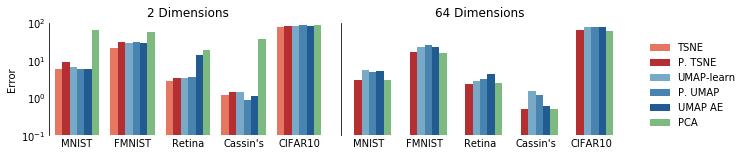

In [12]:
fg = sns.catplot(
    x="dataset",
    y="error",
    hue="method_",
    hue_order=["TSNE","parametric-tsne",  "umap-learn", "network", "autoencoder", "PCA"],
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dimensions",
    height=2.5, 
    aspect=1.75,
    data=median_df,
    kind="bar",
    palette=palette,
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Error")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP-learn')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'autoencoder'))[0][0]].set_text('UMAP AE')
ax.set_ylim([1e-1,100])
ax.set_yscale('log')
#fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')
#ax.set_yscale('log')

#save_fig(FIGURE_DIR/'knn_classifier_results', save_pdf=True, dpi=300, pad_inches=0.1)

### K = 5

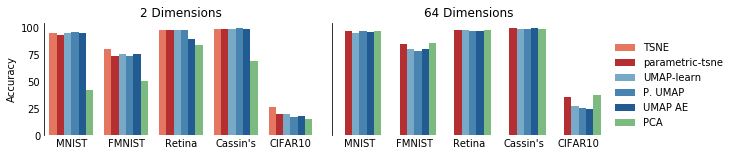

In [13]:
median_df = (
    projection_speeds[["method_", "dimensions", "dataset", "5NN_acc"]]
    .groupby(["method_", "dimensions", "dataset"])
    .median()
)
median_df = median_df.T.melt()
median_df["value"]*=100
median_df["error"] = 100 - median_df["value"]
fg = sns.catplot(
    x="dataset",
    y="value",
    hue="method_",
    hue_order=["TSNE", "parametric-tsne", "umap-learn", "network", "autoencoder", "PCA"],
    order=["mnist", "fmnist", "macosko2015", "cassins_dtw", "cifar10"],
    col="dimensions",
    height=2.5,
    aspect=1.75,
    data=median_df,
    kind="bar",
    palette=palette,
    # legend=False
)
(
    fg.despine(bottom=True)
    .set_xticklabels(["MNIST", "FMNIST", "Retina", "Cassin's", "CIFAR10"])
    .set_axis_labels("", "Accuracy")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u"both", which=u"both", length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "umap-learn"))[0][0]
].set_text("UMAP-learn")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "network"))[0][0]
].set_text("P. UMAP")
fg._legend.texts[
    np.where((np.array([i._text for i in fg._legend.texts]) == "autoencoder"))[0][0]
].set_text("UMAP AE")
# fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'pca'))[0][0]].set_text('PCA')
# fg._legend.texts[3].set_text("PCA")
# ax.set_ylim([1e-10,1e-3])
# ax.set_yscale('log')
# fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title("2 Dimensions")
ax = fg.axes[0][1]
ax.tick_params(axis=u"both", which=u"both", length=0)

ax.set_title("64 Dimensions")
# ax.set_yscale('log')

save_fig(FIGURE_DIR/'5nn_acc_results', save_pdf=True, dpi=300, pad_inches=0.1)

Text(0.5, 1, '64 Dimensions')

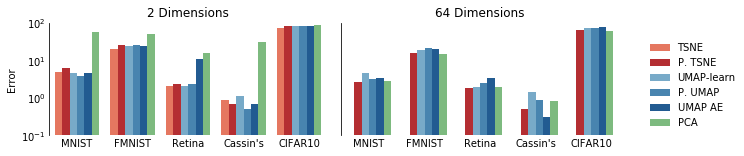

In [14]:
fg = sns.catplot(
    x="dataset",
    y="error",
    hue="method_",
    hue_order=["TSNE", "parametric-tsne", "umap-learn", "network", "autoencoder", "PCA"],
    order = ['mnist', 'fmnist', 'macosko2015', 'cassins_dtw', 'cifar10'],
    col="dimensions",
    height=2.5, 
    aspect=1.75,
    data=median_df,
    kind="bar",
    palette=palette,
    #legend=False
)
(fg.despine(bottom=True)
 .set_xticklabels(['MNIST', 'FMNIST', 'Retina', 'Cassin\'s', 'CIFAR10'])
 .set_axis_labels("", "Error")
)
ax = fg.axes[0][0]
ax.tick_params(axis=u'both', which=u'both',length=0)
fg._legend._legend_title_box._text.set_text("")
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'parametric-tsne'))[0][0]].set_text('P. TSNE')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'umap-learn'))[0][0]].set_text('UMAP-learn')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'network'))[0][0]].set_text('P. UMAP')
fg._legend.texts[np.where((np.array([i._text for i in fg._legend.texts]) == 'autoencoder'))[0][0]].set_text('UMAP AE')
ax.set_ylim([1e-1,100])
ax.set_yscale('log')
#fg._legend.texts[2].set_text("Param. UMAP")

ax.set_title('2 Dimensions')
ax = fg.axes[0][1]
ax.tick_params(axis=u'both', which=u'both',length=0)

ax.set_title('64 Dimensions')
#ax.set_yscale('log')

#save_fig(FIGURE_DIR/'knn_classifier_results', save_pdf=True, dpi=300, pad_inches=0.1)

In [15]:
# 2 AMD EPYC Rome 7252 8-Core 3.1 GHz  processors 

### Make latex table

In [16]:
projection_speeds[:3]

,method_,dimensions,dataset,1NN_acc,5NN_acc
0,network,2,cassins_dtw,0.991,0.995
1,network,64,cassins_dtw,0.988,0.991
2,autoencoder,2,cassins_dtw,0.989,0.993


In [17]:
proj_speed_melt = pd.melt(
    projection_speeds,
    id_vars=["method_", "dimensions", "dataset"],
    value_vars=["1NN_acc", "5NN_acc"],
)
proj_speed_melt.rename(columns={'variable':'metric'}, inplace=True)
proj_speed_melt

,method_,dimensions,dataset,metric,value
0,network,2,cassins_dtw,1NN_acc,0.991000
1,network,64,cassins_dtw,1NN_acc,0.988000
2,autoencoder,2,cassins_dtw,1NN_acc,0.989000
3,autoencoder,64,cassins_dtw,1NN_acc,0.994000
4,umap-learn,2,cassins_dtw,1NN_acc,0.986000
...,...,...,...,...,...
105,parametric-tsne,64,fmnist,5NN_acc,0.847900
106,parametric-tsne,2,macosko2015,5NN_acc,0.976568
107,parametric-tsne,64,macosko2015,5NN_acc,0.981254
108,parametric-tsne,2,mnist,5NN_acc,0.937800


In [18]:
unique_datasets = list(projection_speeds.dataset.unique())
unique_dims = list(projection_speeds.dimensions.unique())
unique_metric = ['1NN_acc', '5NN_acc']
unique_method = list(projection_speeds.method_.unique())
unique_datasets, unique_dims, unique_metric, unique_method

(['cassins_dtw', 'cifar10', 'fmnist', 'macosko2015', 'mnist'],
 [2, 64],
 ['1NN_acc', '5NN_acc'],
 ['network', 'autoencoder', 'umap-learn', 'PCA', 'TSNE', 'parametric-tsne'])

In [19]:
proj_speed_melt[:3]

,method_,dimensions,dataset,metric,value
0,network,2,cassins_dtw,1NN_acc,0.991
1,network,64,cassins_dtw,1NN_acc,0.988
2,autoencoder,2,cassins_dtw,1NN_acc,0.989


In [20]:
r0, r0n = unique_method, "method_" 
r1, r1n = unique_dims, "dimensions"
c0, c0n = unique_datasets, "dataset" 
c1, c1n = unique_metric, "metric"
row_idx = [
    np.concatenate([list(np.repeat(i, len(r1))) for i in r0]),
    np.concatenate([list(r1) for i in r0]),  
]
row_idx = pd.MultiIndex.from_tuples(list(zip(*row_idx)), names=[r0n, r1n])
col_idx = [
    np.concatenate([list(np.repeat(i, len(c1))) for i in c0]),
    np.concatenate([list(c1) for i in c0]),  

]
col_idx = pd.MultiIndex.from_tuples(list(zip(*col_idx)), names=[c0n, c1n])
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
for method_ in unique_method:
    for dataset in unique_datasets:
        for dim in unique_dims:
            for metric in unique_metric:
                val = proj_speed_melt[
                    (proj_speed_melt.dataset == dataset) &
                   (proj_speed_melt.method_ == method_) &
                   (proj_speed_melt.dimensions == dim) & 
                   (proj_speed_melt['metric'] == metric)
                  ]['value']
                if len(val) > 0:
                     results_df.loc[(method_,dim), (dataset, metric)] = round(list(val)[0],3)
results_df

dataset                    cassins_dtw         cifar10          fmnist  \
metric                         1NN_acc 5NN_acc 1NN_acc 5NN_acc 1NN_acc   
method_         dimensions                                               
network         2                0.991   0.995   0.151   0.172   0.694   
                64               0.988   0.991   0.214   0.252   0.743   
autoencoder     2                0.989   0.993   0.159   0.183   0.708   
                64               0.994   0.997   0.222   0.248   0.777   
umap-learn      2                0.986   0.989   0.169   0.194   0.714   
                64               0.985   0.986   0.237   0.269   0.768   
PCA             2                0.626   0.691   0.144   0.150   0.447   
                64               0.995   0.992   0.383   0.377   0.840   
TSNE            2                0.988   0.991   0.246   0.261   0.782   
                64              -1.000  -1.000  -1.000  -1.000  -1.000   
parametric-tsne 2                0.986   0.993   0.168   0.202   0.683   
                64               0.995   0.995   0.343   0.356   0.830   

dataset                            macosko2015           mnist          
metric                     5NN_acc     1NN_acc 5NN_acc 1NN_acc 5NN_acc  
method_         dimensions                                              
network         2            0.741       0.964   0.976   0.940   0.961  
                64           0.788       0.968   0.975   0.952   0.968  
autoencoder     2            0.756       0.858   0.893   0.940   0.954  
                64           0.803       0.958   0.966   0.948   0.965  
umap-learn      2            0.761       0.967   0.979   0.932   0.954  
                64           0.806       0.972   0.980   0.945   0.954  
PCA             2            0.505       0.809   0.843   0.377   0.420  
                64           0.857       0.976   0.981   0.971   0.973  
TSNE            2            0.804       0.972   0.979   0.941   0.950  
                64          -1.000      -1.000  -1.000  -1.000  -1.000  
parametric-tsne 2            0.736       0.966   0.977   0.912   0.938  
                64           0.848       0.977   0.981   0.970   0.973

In [21]:
results_latex = results_df.to_latex(
    bold_rows=True, multirow=True, multicolumn=True, multicolumn_format="l"
)
replace_list = [
    ["\\begin{tabular}", "\\begin{table}\n\\begin{tabular}"],
    ["\\end{tabular}", "\\end{tabular}\n\\end{table}"],
    ["-1.000", "-"],
    ["-1.00", "-"],
    ["fmnist", "\\textbf{FMNIST}"],
    ["mnist", "\\textbf{MNIST}"],
    ["macosko2015", "\\textbf{Retina}"],
    ["cassins\_dtw", "\\textbf{Cassin's}"],
    ["cifar10", "\\textbf{CIFAR10}"],
    ["dataset", ""],
    ["metric", ""],
    ["dimensions", ""],
    ["method_", ""],
    ["1NN\_acc", "k=1"],
    ["5NN\_acc", "k=5"],
    
    ["\\end{tabular}",
     "\\end{tabular}\n\caption{KNN Clustering metrics for each dataset"]
]
for i, j in replace_list:
    results_latex = results_latex.replace(i, j)
print(results_latex)

\begin{table}
\begin{tabular}{llrrrrrrrrrr}
\toprule
                & \textbf{} & \multicolumn{2}{l}{\textbf{Cassin's}} & \multicolumn{2}{l}{\textbf{CIFAR10}} & \multicolumn{2}{l}{\textbf{FMNIST}} & \multicolumn{2}{l}{\textbf{Retina}} & \multicolumn{2}{l}{\textbf{MNIST}} \\
                & \textbf{} &     k=1 & k=5 & k=1 & k=5 & k=1 & k=5 &     k=1 & k=5 & k=1 & k=5 \\
\textbf{method\_} & \textbf{} &             &         &         &         &         &         &             &         &         &         \\
\midrule
\multirow{2}{*}{\textbf{network}} & \textbf{2 } &       0.991 &   0.995 &   0.151 &   0.172 &   0.694 &   0.741 &       0.964 &   0.976 &   0.940 &   0.961 \\
                & \textbf{64} &       0.988 &   0.991 &   0.214 &   0.252 &   0.743 &   0.788 &       0.968 &   0.975 &   0.952 &   0.968 \\
\cline{1-12}
\multirow{2}{*}{\textbf{autoencoder}} & \textbf{2 } &       0.989 &   0.993 &   0.159 &   0.183 &   0.708 &   0.756 &       0.858 &   0.893 &   0.940 &   0.954 \\

In [22]:
col_idx

MultiIndex([('cassins_dtw', '1NN_acc'),
            ('cassins_dtw', '5NN_acc'),
            (    'cifar10', '1NN_acc'),
            (    'cifar10', '5NN_acc'),
            (     'fmnist', '1NN_acc'),
            (     'fmnist', '5NN_acc'),
            ('macosko2015', '1NN_acc'),
            ('macosko2015', '5NN_acc'),
            (      'mnist', '1NN_acc'),
            (      'mnist', '5NN_acc')],
           names=['dataset', 'metric'])

In [23]:
r0, r0n = unique_method, "method_" 
r1, r1n = unique_dims, "dimensions"
c0, c0n = unique_datasets, "dataset" 
c1, c1n = unique_metric, "metric"
row_idx = [list(r0)]
row_idx = pd.MultiIndex.from_tuples(list(zip(*row_idx)), names=[r0n])
col_idx = [
    np.concatenate([list(np.repeat(i, len(c1)*len(r1))) for i in c0]),
    np.concatenate([list(np.repeat(r1, len(c1))) for j in r1 for i in c0]),
    np.concatenate([list(c1) for j in r1  for i in c0]),  

]
col_idx = pd.MultiIndex.from_tuples(list(zip(*col_idx)), names=[c0n, r1n,c1n])
results_df = pd.DataFrame(-1*np.ones((len(row_idx), len(col_idx))), index=row_idx, columns=col_idx)
for method_ in unique_method:
    for dataset in unique_datasets:
        for dim in unique_dims:
            for metric in unique_metric:
                val = proj_speed_melt[
                    (proj_speed_melt.dataset == dataset) &
                   (proj_speed_melt.method_ == method_) &
                   (proj_speed_melt.dimensions == dim) & 
                   (proj_speed_melt['metric'] == metric)
                  ]['value']
                if len(val) > 0:
                     results_df.loc[method_, (dataset, dim ,metric)] = round(list(val)[0],3)
results_df


dataset         cassins_dtw                         cifar10                  \
dimensions               2               64              2               64   
metric              1NN_acc 5NN_acc 1NN_acc 5NN_acc 1NN_acc 5NN_acc 1NN_acc   
method_                                                                       
network               0.991   0.995   0.988   0.991   0.151   0.172   0.214   
autoencoder           0.989   0.993   0.994   0.997   0.159   0.183   0.222   
umap-learn            0.986   0.989   0.985   0.986   0.169   0.194   0.237   
PCA                   0.626   0.691   0.995   0.992   0.144   0.150   0.383   
TSNE                  0.988   0.991  -1.000  -1.000   0.246   0.261  -1.000   
parametric-tsne       0.986   0.993   0.995   0.995   0.168   0.202   0.343   

dataset                  fmnist                         macosko2015          \
dimensions                   2               64                  2            
metric          5NN_acc 1NN_acc 5NN_acc 1NN_acc 5NN_acc     1NN_acc 5NN_acc   
method_                                                                       
network           0.252   0.694   0.741   0.743   0.788       0.964   0.976   
autoencoder       0.248   0.708   0.756   0.777   0.803       0.858   0.893   
umap-learn        0.269   0.714   0.761   0.768   0.806       0.967   0.979   
PCA               0.377   0.447   0.505   0.840   0.857       0.809   0.843   
TSNE             -1.000   0.782   0.804  -1.000  -1.000       0.972   0.979   
parametric-tsne   0.356   0.683   0.736   0.830   0.848       0.966   0.977   

dataset                           mnist                          
dimensions           64              2               64          
metric          1NN_acc 5NN_acc 1NN_acc 5NN_acc 1NN_acc 5NN_acc  
method_                                                          
network           0.968   0.975   0.940   0.961   0.952   0.968  
autoencoder       0.958   0.966   0.940   0.954   0.948   0.965  
umap-learn        0.972   0.980   0.932   0.954   0.945   0.954  
PCA               0.976   0.981   0.377   0.420   0.971   0.973  
TSNE             -1.000  -1.000   0.941   0.950  -1.000  -1.000  
parametric-tsne   0.977   0.981   0.912   0.938   0.970   0.973

In [24]:
results_latex = results_df.to_latex(
    bold_rows=True, multirow=True, multicolumn=True, multicolumn_format="l"
)
replace_list = [
    ["\\begin{tabular}", "\\begin{table}\n\\begin{tabular}"],
    ["\\end{tabular}", "\\end{tabular}\n\\end{table}"],
    ["-1.000", "-"],
    ["-1.00", "-"],
    ["fmnist", "\\textbf{FMNIST}"],
    ["mnist", "\\textbf{MNIST}"],
    ["macosko2015", "\\textbf{Retina}"],
    ["cassins\_dtw", "\\textbf{Cassin's}"],
    ["cifar10", "\\textbf{CIFAR10}"],
    ["dataset", ""],
    ["metric", ""],
    ["dimensions", ""],
    ["method_", ""],
    ["1NN\_acc", "k=1"],
    ["5NN\_acc", "k=5"],
    
    ["\\end{tabular}",
     "\\end{tabular}\n\caption{KNN Clustering metrics for each dataset"]
]
for i, j in replace_list:
    results_latex = results_latex.replace(i, j)
print(results_latex)

\begin{table}
\begin{tabular}{lrrrrrrrrrrrrrrrrrrrr}
\toprule
\textbf{} & \multicolumn{4}{l}{\textbf{Cassin's}} & \multicolumn{4}{l}{\textbf{CIFAR10}} & \multicolumn{4}{l}{\textbf{FMNIST}} & \multicolumn{4}{l}{\textbf{Retina}} & \multicolumn{4}{l}{\textbf{MNIST}} \\
\textbf{} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{64} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{64} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{64} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{64} & \multicolumn{2}{l}{2} & \multicolumn{2}{l}{64} \\
\textbf{} &     k=1 & k=5 & k=1 & k=5 & k=1 & k=5 & k=1 & k=5 & k=1 & k=5 & k=1 & k=5 &     k=1 & k=5 & k=1 & k=5 & k=1 & k=5 & k=1 & k=5 \\
\textbf{method\_} &             &         &         &         &         &         &         &         &         &         &         &         &             &         &         &         &         &         &         &         \\
\midrule
\textbf{network} &       0.991 &   0.995 &   0.988 &   0.991 &   0.151 &   0.172 &   0.214 &   0